## Введение в глубокое обучение
### Занятие 3. Методы регуляризации в DL

##### *Credits: First part is deeply based on demo done by Andrej Karpathy for CS 231n:* https://cs231n.github.io/neural-networks-case-study/

#### План занятия:
0. Повторение функций активации и их свойств
1. Анализ градиентов для различных функций активации
2. Обзор методов регуляризации в нейронных сетях
    * Batch Normalization
    * L1/L2 (weight decay)
    * Dropout
    * Аугментации (Data augmentation)
3. Базовая работа с текстовыми данными, решение задачи классификации теста
4. Использование Dropout для повышения устойчивости модели

In [51]:
!pip install torch

In [3]:
import numpy as np
import torch
print('PyTorch version: {}'.format(torch.__version__))
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

PyTorch version: 2.3.1+cpu


### 1. Затухающие градиенты и различные функции активации
Сгенерируем простой двухмерный датасет для задачи классификации. Выборка линейно неразделима, поэтому обратимся к нейронным сетям.

(-1.0, 1.0)

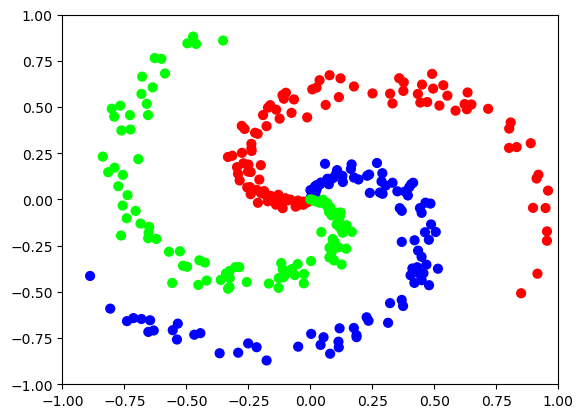

In [4]:
#generate random data -- not linearly separable
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.brg)
plt.xlim([-1,1])
plt.ylim([-1,1])


Воспользуемся простой нейронной сетью с двумя скрытыми слоями для решения данной задачи. В качестве функций активации будем использовать `Sigmoid` и `ReLU`.

In [5]:
N_FEATURES_SMALL = 2
N_CLASSES_SMALL = 3
NUM_EPOCH = 50000

Для удобства ниже реализована функция, конструирующая модель. Функция активации и размер скрытого представления выступают в роли гиперпараметров.

In [6]:
def create_model(activation, hid_size=50, num_features=N_FEATURES_SMALL, n_out=N_CLASSES_SMALL):
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(num_features, hid_size))
    model.add_module('activation1', activation())
    model.add_module('l2', nn.Linear(hid_size, hid_size))
    model.add_module('activation2', activation())
    model.add_module('l3', nn.Linear(hid_size, n_out))

    return model

Следующая функция обучает модель и логгирует полезную информацию.

In [7]:
model_relu = create_model(nn.ReLU)

In [8]:
def train_model(model, X_train, y_train):
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.1)


    loss_history, var_layer_1, var_layer_2, var_layer_3 = [], [], [], []

    for epoch_num in range(NUM_EPOCH):
        opt.zero_grad()

        y_predicted = model(X_train)
        loss = loss_function(y_predicted, y_train)
        reg = 0.01 * (torch.norm(model[0].weight) \
                      + torch.norm(model[2].weight) \
                      + torch.norm(model[4].weight))
        loss += reg
        loss.backward()
        opt.step()

        loss_history.append(loss.item()) # Always use .item() to store scalars in logs!

        var_layer_1.append(torch.sum(torch.abs(model[0].weight.grad)).item()/model[0].weight.shape[0])
        var_layer_2.append(torch.sum(torch.abs(model[2].weight.grad)).item()/model[2].weight.shape[0])
        var_layer_3.append(torch.sum(torch.abs(model[4].weight.grad)).item()/model[4].weight.shape[0])

    return model, loss_history, var_layer_1, var_layer_2, var_layer_3

In [9]:
X_torch = torch.FloatTensor(X)
y_torch = torch.LongTensor(y)

In [10]:
model_relu = create_model(nn.ReLU)
model_sigmoid = create_model(nn.Sigmoid)

In [11]:
%%time
out_relu = train_model(model_relu, X_torch, y_torch)

CPU times: total: 5min 37s
Wall time: 2min 9s


In [12]:
%%time
out_sigmoid = train_model(model_sigmoid, X_torch, y_torch)

CPU times: total: 6min 2s
Wall time: 2min 15s


Рассмотрим среднее значение градиента на каждом из слоев. Можно заметить, что чем "дальше" слой от функции потерь, тем меньший градиент получают его параметры.

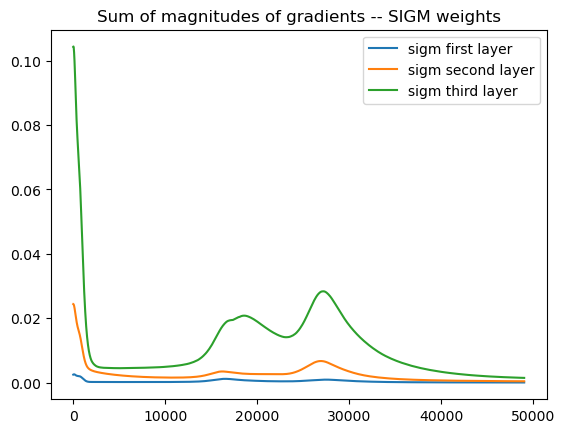

In [13]:
plt.plot(np.array(out_sigmoid[2][1000:]), label="sigm first layer")
plt.plot(np.array(out_sigmoid[3][1000:]), label="sigm second layer")
plt.plot(np.array(out_sigmoid[4][1000:]), label="sigm third layer")
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend()

Рассмотрим аналогичный график для функции активации `ReLU`:

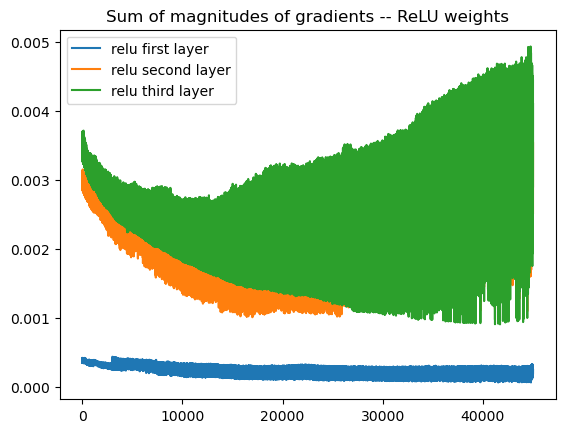

In [14]:
plt.plot(np.array(out_relu[2][5000:]), label="relu first layer")
plt.plot(np.array(out_relu[3][5000:]), label="relu second layer")
plt.plot(np.array(out_relu[4][5000:]), label="relu third layer")
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend()

И объединим все результаты на едином графике:

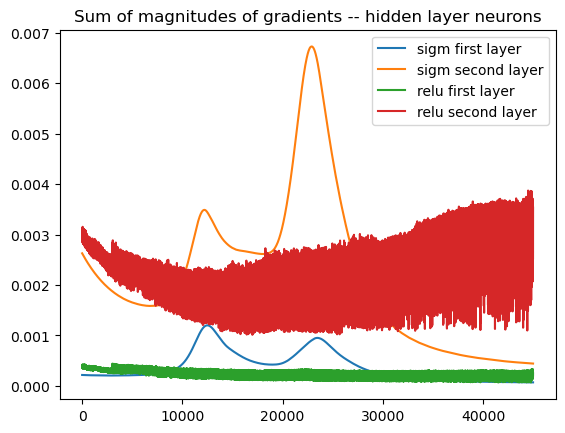

In [15]:
# Overlaying the two plots to compare
plt.plot(np.array(out_sigmoid[2][5:][5000:]), label="sigm first layer")
plt.plot(np.array(out_sigmoid[3][5:][5000:]), label="sigm second layer")
# plt.plot(np.array(out_sigmoid[4]), label="sigm third layer")

plt.plot(np.array(out_relu[2][5:][5000:]), label="relu first layer")
plt.plot(np.array(out_relu[3][5:][5000:]), label="relu second layer")
# plt.plot(np.array(out_relu[4]), label="relu third layer")

plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend()

Как видим, градиенты на более "далеких от функции потерь" слоях в среднем значительно ниже чем на "более близких".

Попробуйте изменить гиперпараметры и структуру сети. Можете попробовать ответить на следующие вопросы:

* Как изменится поведение сети, если изменить коэффициент регуляризации?
* Как изменится поведение сети, если изменить `learning rate`?


Также стоит обратить внимание на итоговое качество решения задачи. Для `Sigmoid` может понадобиться большее число итераций или значение `learning rate`.

In [16]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_draw = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

(-1.8712034092398278, 1.8687965907601756)

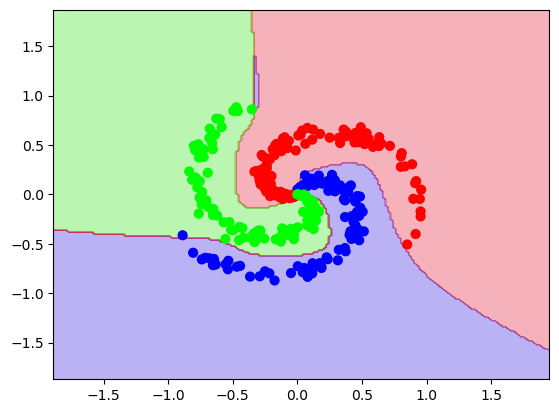

In [17]:
with torch.no_grad():
    Z = model_sigmoid(X_draw).numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.brg, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.brg)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.8712034092398278, 1.8687965907601756)

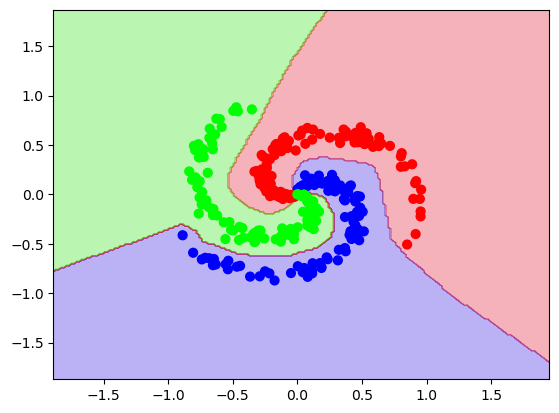

In [18]:
with torch.no_grad():
    Z = model_relu(X_draw).numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.brg, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.brg)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

#### 2. Работа с текстами и последовательностями
В данном занятии мы переходим к работе с данными, обладающими некоторой внутренней структурой. Введем определение для последовательностей и текстов в частности.
* __Последовательность__ представляет собой набор значений, на которых задано некоторое отношение порядка. Значения могут быть как дискретными (например, в ДНК), так и принимать значения из непрерывного интервала (например, история цен на бирже). Порядок значений играет роль, их перестановка приведет к потере информации. Если присутствует упорядоченность по времени, то стоит помнить, что нельзя ее нарушать.

* __Тексты__ являются частным случаем последовательностей и являются последовательностями значений из дискретного и конечного алфавита. Ввиду существования грамматики они обладают достаточно строгой внутренней структурой.

Для иллюстрации работы с текстами обратимся к задаче классификации отзывов. Для этого воспользуемся широко известным датасетом [SST2](https://nlp.stanford.edu/sentiment/index.html). Для каждого отзыва о фильме доступна метка класса:

1 - для положительных отзывов

0 - для негативных.

Пример данных доступен ниже:

In [19]:
from collections import Counter

import numpy as np
import pandas as pd

from nltk.tokenize import WordPunctTokenizer

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
from IPython import display
%matplotlib inline

In [20]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

In [21]:
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [22]:
df.values[2]

array(["they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes",
       0], dtype=object)

In [23]:
texts = df[0].values[:5000]
labels = df[1].values[:5000]

In [24]:
df.shape

(6920, 2)

In [25]:
texts_test = df[0].values[5000:]
labels_test = df[1].values[5000:]

Текст отличается от привычных нам данных сразу несколькими свойствами:
1. Текст представляет собой последовательность токенов из конечного алфавита, т.е. все элементы последовательности принимают дискретные значения.
2. Текст может быть _переменной длины_.

На втором свойстве мы остановимся подробнее.

До текущего момента используемые нейронные сети работали лишь с данными фиксированной размерности. Для работы с текстами нужно либо предложить метод представления текста в виде вектора фиксированной размерности, либо адаптировать структуру нейронной сети для работы с последовательностями. Сегодня мы остановимся на первом подходе.

Введем еще один необходимый термин:
__Токен__ – минимальный и неделимый элемент текстовой последовательности. В зависимости от выбора эксперта, в качестве токенов могут выступать как символы, так и морфемы, слова или даже группы слов.

Для начала построим _словарь_ из всех возможных токенов. Он будет отображать токен в его индекс. Воспользуемся [collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter) чтобы также оценить частоту встречаемости слов в наборе данных.

In [26]:
tokenizer = WordPunctTokenizer()

In [27]:
tokenizer.tokenize('This is another text, I am really sure!')

['This', 'is', 'another', 'text', ',', 'I', 'am', 'really', 'sure', '!']

In [28]:
counter = Counter()

for text in texts:
    counter.update(tokenizer.tokenize(text.lower()))

tokens = set([token for token, count in counter.items() if count > 5])

token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [29]:
len(tokens)

1839

Теперь представим каждый токен в виде вектора с помощью one-hot кодирования. Каждому токену в словаре был сопоставлен уникальный индекс. Тогда токену можно поставить в соответствие вектор размера словаря, где единственное ненулевое значение стоит на соответствующей токену позиции.

Например, слово "самолет" сопоставлено индексу 0, а размерность словаря 5. Данному токену соответствует вектор `[1, 0, 0, 0, 0]`. Слово "обед" сопоставлено индексу 4, поэтому ему соответствует вектор `[0, 0, 0, 0, 1]`.

Для представления текста в виде вектора фиксированной размерности можно просто учесть все входящие в него токены, игнорируя их порядок. Этот подход называется __мешком слов__, или же __Bag of Words, BoW__. Конечно, он теряет большое количество информации, но все еще может быть использован в некоторых задачах (с небольшими усовершенствованиями).

In [30]:
def text_to_bow(text):
    bow = np.zeros(len(token_to_idx))

    for token in tokenizer.tokenize(text):
        if token in tokens:
            bow[token_to_idx[token]] += 1
    return bow

In [31]:
texts[17]

'as quiet , patient and tenacious as mr lopez himself , who approaches his difficult , endless work with remarkable serenity and discipline'

In [32]:
text_to_bow(texts[17])

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
sum(text_to_bow(texts[17]))

16.0

In [34]:
len(tokenizer.tokenize(texts[17]))

23

In [35]:
[(token in tokens) for token in tokenizer.tokenize(texts[17])]

[True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False]

In [36]:
Counter(labels)

Counter({1: 2607, 0: 2393})

In [37]:
X_train_bow = np.stack(list(map(text_to_bow, texts)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

Для начала построим простую логистическую регрессию из `sklearn` в качестве baseline.

In [38]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, labels)

train accuracy 0.9012
test accuracy 0.7739583333333333


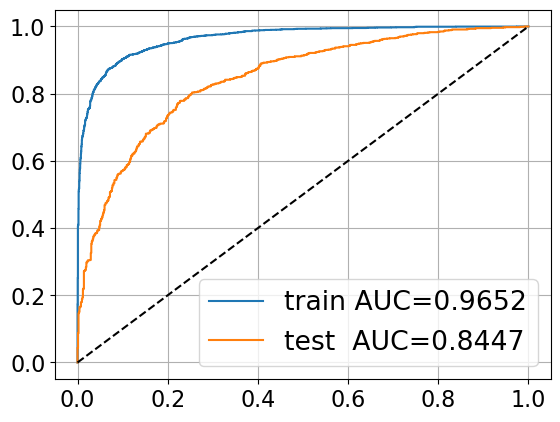

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

for name, X, y, model in [
    ('train', X_train_bow, labels, bow_model),
    ('test ', X_test_bow, labels_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

print('train accuracy', accuracy_score(model.predict(X_train_bow), labels))
print('test accuracy', accuracy_score(model.predict(X_test_bow), labels_test))



In [40]:
# Gini == AUC*2-1

In [41]:
X_train_bow.shape, X_test_bow.shape

((5000, 1839), (1920, 1839))

In [42]:
NUM_FEATURES = len(tokens)

Теперь можно построить простую нейронную сеть для кассификации данных отзывов.

In [43]:
model = nn.Sequential()
model.add_module('dropout', nn.Dropout(p=0.8))
model.add_module('l1', nn.Linear(NUM_FEATURES, 16))
model.add_module('relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.8))
model.add_module('l2', nn.Linear(16, 2))
model.add_module('logit', nn.Sigmoid())

In [44]:
loss_function = nn.CrossEntropyLoss()

In [45]:
opt = torch.optim.RMSprop(model.parameters(), lr=1e-2)

# lr_scheduler = ReduceLROnPlateau(opt)

In [46]:
X_train_bow_torch = torch.FloatTensor(X_train_bow)
X_test_bow_torch = torch.FloatTensor(X_test_bow)

y_train_torch = torch.LongTensor(labels)
y_test_torch = torch.LongTensor(labels_test)

In [47]:
n_iterations = 2000
batch_size = 256
train_loss_history = []
train_acc_history = []
plot_history = []
test_plot_history = []

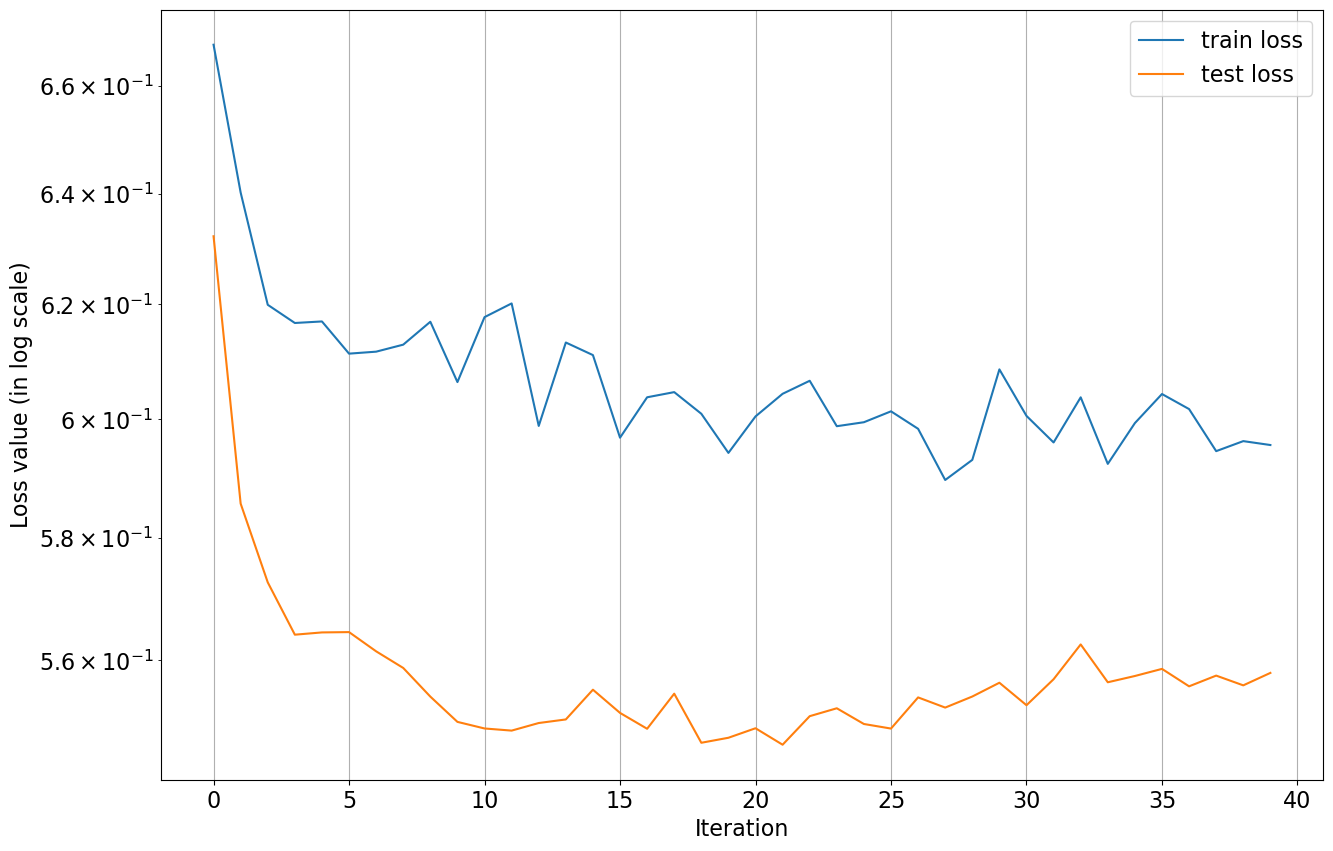

In [48]:
for _i in range(n_iterations):
    model.train()
    opt.zero_grad()

    ix = np.random.randint(0, len(X_train_bow_torch), batch_size)
    x_batch = X_train_bow_torch[ix]
    y_batch = y_train_torch[ix]

    y_predicted = model(x_batch)
    loss = loss_function(y_predicted, y_batch)
    loss.backward()
    opt.step()

    train_loss_history.append(loss.data.numpy())
    train_acc_history.append(
        accuracy_score(
            y_batch.detach().numpy(),
            y_predicted.detach().numpy().argmax(axis=1)
        )
    )

    if (_i+25) % 50==0:
        model.eval()
        plot_history.append(np.mean(train_loss_history[-10:]))
        test_plot_history.append(loss_function(model(X_test_bow_torch), y_test_torch).item())


        display.clear_output(True)
        plt.figure(figsize=(15, 10))
        plt.plot(plot_history, label='train loss')
        plt.plot(test_plot_history, label='test loss')
        plt.yscale('log')
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Loss value (in log scale)')
        plt.legend()
        plt.show()

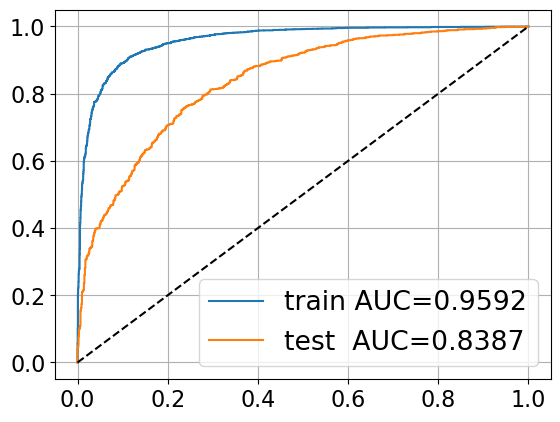

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, labels, model),
    ('test ', X_test_bow_torch, labels_test, model)
]:
    model.eval()
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [50]:
train_predictions = torch.max(model(X_train_bow_torch).detach().cpu(), dim=1)[1].numpy()
test_predictions = torch.max(model(X_test_bow_torch).detach().cpu(), dim=1)[1].numpy()

print('train accuracy', accuracy_score(train_predictions, labels))
print('test accuracy', accuracy_score(test_predictions, labels_test))

train accuracy 0.9042
test accuracy 0.7604166666666666


Видим, что сеть достаточно сильно переобучается. Попробуем воспользоваться изученными техниками регуляризации, например, Dropout.

Обращаем ваше внимание на то, что Dropout можно использовать как для промежуточных представлений, так и для исходного признакового описания данных.

### Выводы:
* Различные функции активации обладают различными свойствами. О них стоит помнить, используя их на практике. Отличное решение по умолчанию: `ReLU`;
* Затухающие градиенты – существенная проблема для нейронных сетей. В целом она свойственна любым нейронным сетям, но больше всего проявляет себя в глубоких сетях. Методы частичного решения этой проблемы будут рассмотрены в дальнейшем;
* Вносите ограничения на веса, структуру модели или данные, если они обусловлены решаемой задачей или экспертными знаниями;
* Dropout позволяет получить более устойчивую модель;
* Аугментации данных должны быть осмысленными;
* Dropout в некотором смысле эквивалентен ансаблированию моделей.